<a href="https://colab.research.google.com/github/getmubarak/ML/blob/master/Algorithms/keras/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from google.colab import drive
import matplotlib.pyplot as plt

import sys

import numpy as np

In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        print("-----------------")
        #fig.savefig("/gdrive/My Drive/DCGAN/MNIST/mnist_%d.png" % epoch)
        #plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_8 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.112723, acc.: 21.88%] [G loss: 0.912556]
-----------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.660738, acc.: 64.06%] [G loss: 1.191224]
2 [D loss: 0.462165, acc.: 75.00%] [G loss: 1.234985]
3 [D loss: 0.301481, acc.: 90.62%] [G loss: 1.376654]
4 [D loss: 0.219942, acc.: 95.31%] [G loss: 1.487711]
5 [D loss: 0.138622, acc.: 98.44%] [G loss: 0.608680]
6 [D loss: 0.108024, acc.: 98.44%] [G loss: 0.583659]
7 [D loss: 0.131221, acc.: 96.88%] [G loss: 0.496247]
8 [D loss: 0.143735, acc.: 96.88%] [G loss: 0.572627]
9 [D loss: 0.331722, acc.: 85.94%] [G loss: 0.658231]


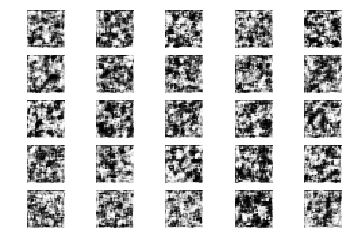

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.203271, acc.: 37.50%] [G loss: 0.588705]
-----------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.716688, acc.: 64.06%] [G loss: 1.100346]
2 [D loss: 0.542027, acc.: 68.75%] [G loss: 1.761635]
3 [D loss: 0.345979, acc.: 85.94%] [G loss: 1.739205]
4 [D loss: 0.201622, acc.: 93.75%] [G loss: 1.224306]
5 [D loss: 0.164345, acc.: 96.88%] [G loss: 0.674948]
-----------------
6 [D loss: 0.123939, acc.: 96.88%] [G loss: 0.416850]
7 [D loss: 0.088140, acc.: 98.44%] [G loss: 0.426605]
8 [D loss: 0.144603, acc.: 93.75%] [G loss: 0.632695]
9 [D loss: 0.097437, acc.: 98.44%] [G loss: 0.810986]


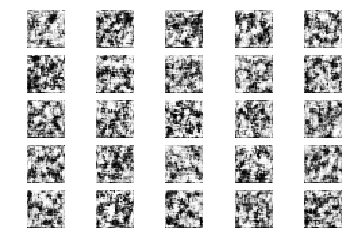

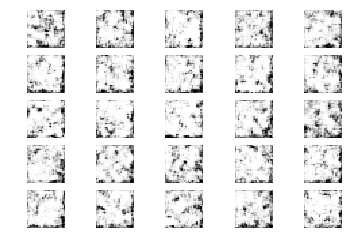

In [19]:
dcgan = DCGAN()
dcgan.train(epochs=10, batch_size=32, save_interval=5)